**Import Tensorflow as Neural Network package**

In [ ]:
import pandas as pd 
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
import tensorflow as tf

In [11]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.18.0


In [12]:
Data = pd.read_csv("../../4 - Data/04_WorkingDatasets/NormalDataLaggedTarget/WDFTargetLagged.csv")
Target = pd.read_csv("../../4 - Data/04_WorkingDatasets/NormalDataLaggedTarget/TargetOutliersTreated.csv")

In [13]:
Target.head()

#Data.drop(columns = ['Datum'], inplace = True)
Data.head()


,Rebgassechange,Clarahuuschange,Citychange,Storchenchange,Post Baselchange,Aeschenchange,Bahnhof Südchange,Bad. Bahnhofchange,Europechange,Claramattechange,...,PM2.5 [ug/m3],CPC [1/cm3],PREC [mm],RAD [W/m2],SO2 [ug/m3],NOX [ug/m3 eq. NO2],TEMP [C],PM10_1h_lag,PM10_2h_lag,PM10_24h_lag
0,-0.069723,-0.000039,-0.010908,-0.175172,0.000008,0.000005,-0.245170,-0.052815,-0.000129,9.531997e-17,...,1.069597,0.510222,-0.152269,-0.639512,0.295487,1.099745,-1.039634,0.096166,0.010001,5.637085
1,0.000222,-0.000039,-0.000018,0.000017,0.000008,0.000005,0.000040,-0.000251,-0.000129,9.531997e-17,...,0.826050,0.216428,-0.152269,-0.639512,0.295487,0.836950,-1.052245,0.017932,0.096179,3.190429
2,0.000222,-0.000039,-0.000018,-0.058380,0.000008,0.000005,0.490459,0.104878,-0.000129,9.531997e-17,...,0.754418,0.090215,-0.152269,-0.639512,0.168683,0.774379,-1.115300,-0.185601,0.017946,1.511672
3,0.000222,-0.000039,0.010872,0.058413,0.000008,0.000005,0.245250,0.104878,0.150828,9.531997e-17,...,0.725766,0.447317,-0.152269,-0.639512,0.422291,0.993376,-1.216189,-0.296032,-0.185588,-0.690209
4,0.140113,-0.000039,0.903873,-0.058380,0.382243,0.000005,0.000040,-0.157943,0.150828,9.531997e-17,...,0.697113,0.316550,-0.152269,-0.639512,0.295487,1.093488,-1.291856,-0.490289,-0.296019,-1.257621


In [14]:
#Lag Feature einbauen, da die Feinstaubkonzentration häufig von den Werten der letzten Tage abhängt 
lag_hours = 24

# Erstelle für jede Stunde in der Vergangenheit eine Lag-Feature-Spalte
for lag in range(1, lag_hours + 1):  
    Data[f'Feature_lag_{lag}'] = Target['PM10_Combined_Trend_Residual'].shift(lag)

# Entfernen von Zeilen mit NaN-Werten, die durch das Verschieben der Daten entstehen
Data.dropna(inplace=True)
# Stelle sicher, dass du NaN-Werte aus beiden X und y entfernst

# Stelle sicher, dass Target denselben Index hat wie Data
Target = Target.loc[Data.index]



In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Data = scaler.fit_transform(Data)

In [16]:
# Beispiel: Annahme, X.shape[0] = 1000 (1000 Zeitpunkte)
n = Data.shape[0]
X = Data.copy()
y = Target["PM10_Combined_Trend_Residual"].copy()

# Split-Größen definieren
train_size = int(n * 0.7)  # 70% Training
val_size = int(n * 0.2)    # 20% Validierung
test_size = n - train_size - val_size  # 10% Test

# Training (älteste Daten)
X_train, y_train = X[:train_size], y[:train_size]

# Validierung (neuere Daten)
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]

# Test (neueste Daten)
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]


In [17]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
optimizer = Adam(learning_rate=0.002)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

In [19]:
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=20,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

In [20]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=64, callbacks=[early_stopping])


Epoch 1/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 51.6486 - mae: 4.7630 - mse: 49.4305 - val_loss: 21.4920 - val_mae: 2.5430 - val_mse: 19.3399
Epoch 2/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11.6974 - mae: 2.2496 - mse: 9.5823 - val_loss: 20.9267 - val_mae: 2.5553 - val_mse: 18.9102
Epoch 3/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.3569 - mae: 2.0897 - mse: 8.3758 - val_loss: 20.6541 - val_mae: 2.6588 - val_mse: 18.7830
Epoch 4/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.0634 - mae: 2.0277 - mse: 8.2231 - val_loss: 18.1109 - val_mae: 2.3608 - val_mse: 16.3689
Epoch 5/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.0048 - mae: 1.9457 - mse: 7.2983 - val_loss: 18.9688 - val_mae: 2.5489 - val_mse: 17.3550
Epoch 6/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.7865 - mae: 1.9047 - mse: 7.2023 - val_loss: 18.8889 - val_mae: 2.6373 - val_mse: 17.3926
Epoch 7/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.7980 - mae: 1.

In [21]:
print(X_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in X_test
print(y_test.shape)  # Zeigt die Anzahl der Zeilen (Samples) in y_test


(2453, 191)
(2453,)


In [22]:
results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.3691 - mae: 1.7407 - mse: 5.4919  
Test loss, Test MAE: [6.462099552154541, 1.7464323043823242, 5.584897518157959]


In [23]:
model2 = Sequential([
    Dense(512, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.005)),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.0015)
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=15,  # Training stoppt, wenn sich der Validierungs-Loss 5 Epochs lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=64, callbacks=[early_stopping])

results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)


Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 39.1984 - mae: 4.0685 - mse: 37.7842 - val_loss: 20.3935 - val_mae: 2.5761 - val_mse: 19.0001
Epoch 2/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.6905 - mae: 2.0643 - mse: 8.3095 - val_loss: 22.5522 - val_mae: 2.9427 - val_mse: 21.2076
Epoch 3/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.3384 - mae: 1.9868 - mse: 8.0082 - val_loss: 18.0288 - val_mae: 2.4151 - val_mse: 16.7389
Epoch 4/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6622 - mae: 1.9429 - mse: 7.3875 - val_loss: 18.6856 - val_mae: 2.4502 - val_mse: 17.4608
Epoch 5/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.3613 - mae: 1.8581 - mse: 7.1508 - val_loss: 18.3356 - val_mae: 2.5585 - val_mse: 17.1731
Epoch 6/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8324 - mae: 1.8203 - mse: 6.6843 - val_loss: 19.3176 - val_mae: 2.6335 - val_mse: 18.2182
Epoch 7/800
269/269 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.6972 - mae: 1.8248 - mse: 6.6

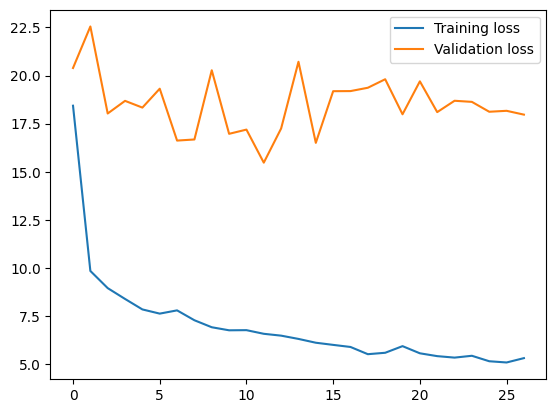

In [24]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'], label='Training loss')
plt.plot(history2.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


In [ ]:
model3 = Sequential([
    Dense(512, activation='relu', input_shape=(Data.shape[1],), kernel_regularizer=l2(0.025)),
    Dropout(0.15),
    Dense(256, activation='relu'),
    Dropout(0.38),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

optimizer = Adam(learning_rate=0.001)
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
# Early Stopping Callback
early_stopping = EarlyStopping(
    patience=38,  # Training stoppt, wenn sich der Validierungs-Loss 15 Epochen lang nicht verbessert
    restore_best_weights=True  # Die besten Gewichte werden zurückgeladen
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.38, patience=10, min_lr=1e-6) # Vorschläge aus dem Internet testen



history3 = model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=800, batch_size=16, callbacks=[early_stopping, lr_scheduler])

results = model.evaluate(X_test, y_test)
print("Test loss, Test MAE:", results)

Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1073/1073 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 27.4327 - mae: 3.1243 - mse: 21.2076 - val_loss: 21.0502 - val_mae: 2.2349 - val_mse: 17.1433 - learning_rate: 0.0010
Epoch 2/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 12.0281 - mae: 2.1396 - mse: 8.6598 - val_loss: 30.0546 - val_mae: 3.6331 - val_mse: 27.8017 - learning_rate: 0.0010
Epoch 3/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 14.0026 - mae: 2.3556 - mse: 11.8724 - val_loss: 17.3834 - val_mae: 2.1669 - val_mse: 15.8526 - learning_rate: 0.0010
Epoch 4/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.6979 - mae: 1.9583 - mse: 7.2725 - val_loss: 17.0228 - val_mae: 2.3431 - val_mse: 15.7550 - learning_rate: 0.0010
Epoch 5/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 8.7705 - mae: 1.9447 - mse: 7.5657 - val_loss: 16.3272 - val_mae: 2.1953 - val_mse: 15.2373 - learning_rate: 0.0010
Epoch 6/800
1073/1073 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 7.5824 - mae: 1.8359 - mse: 6.5752 - val_loss: 16

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7661 - mae: 1.4841 - mse: 4.2201  
Test loss, Test MAE: [5.42454195022583, 1.6282896995544434, 4.878493785858154]

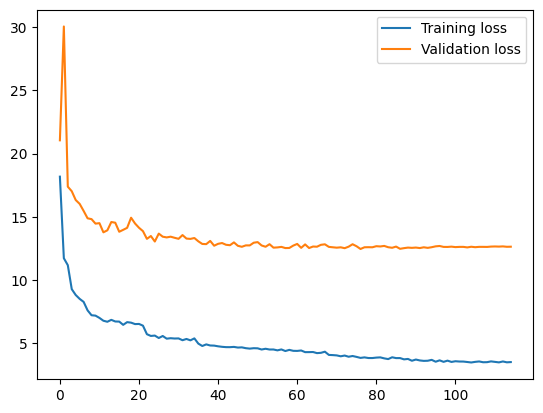

In [26]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()


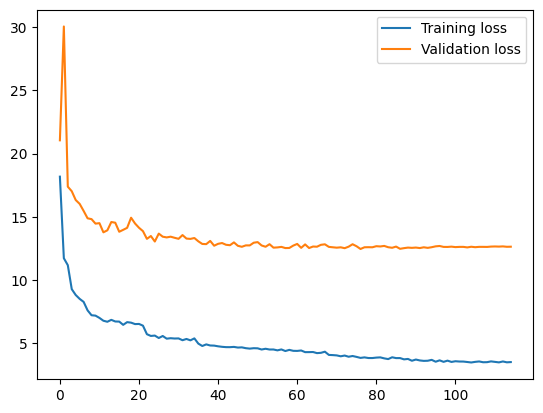

In [27]:
import matplotlib.pyplot as plt
plt.plot(history3.history['loss'], label='Training loss')
plt.plot(history3.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [33]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

# Beispiel: Zeitreihen-Daten
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

X = pd.DataFrame(X)
y = pd.DataFrame(y)

# Hyperparameter-Suchraum
l2_values = [0.01, 0.025, 0.05, 0.08]
learning_rates = [0.001, 0.002, 0.004, 0.006, 0.008]
patience_values = [72]
batch_sizes = [32]

# Ergebnis speichern
best_params = None
best_loss = float("inf")

# Schleife über den Suchraum
for l2_value in l2_values:
    for lr in learning_rates:
        for patience in patience_values:
            for batch_size in batch_sizes:
                print(f"Testing with L2: {l2_value}, LR: {lr}, Patience: {patience}, Batch size: {batch_size}")
                
                # Cross-Validation
                fold_losses = []
                for train_index, val_index in tscv.split(X):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

                    # Modell definieren
                    model = Sequential([
                        Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(l2_value)),
                        Dropout(0.15),
                        Dense(256, activation='relu'),
                        Dropout(0.38),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(1, activation='relu'),
                    ])
                    
                    # Optimizer und Kompilierung
                    optimizer = Adam(learning_rate=lr)
                    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

                    # Early Stopping Callback
                    early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)

                    # Trainieren
                    history = model.fit(
                        X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=800,
                        batch_size=batch_size,
                        callbacks=[early_stopping],
                        verbose=0
                    )

                    # Validierungsergebnis
                    val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
                    fold_losses.append(val_loss)

                # Durchschnittlicher Loss für alle Folds
                mean_loss = np.mean(fold_losses)
                print(f"Mean Validation Loss: {mean_loss}")

                # Beste Hyperparameter speichern
                if mean_loss < best_loss:
                    best_loss = mean_loss
                    best_params = {
                        'l2': l2_value,
                        'learning_rate': lr,
                        'patience': patience,
                        'batch_size': batch_size
                    }

# Ergebnisse
print("Best Hyperparameters:")
print(best_params)
print(f"Best Loss: {best_loss}")

# Trainieren mit den besten Hyperparametern auf Train+Validation und Test auf Testdaten
final_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(best_params['l2'])),
    Dropout(0.15),
    Dense(256, activation='relu'),
    Dropout(0.38),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='relu'),
])

final_optimizer = Adam(learning_rate=best_params['learning_rate'])
final_model.compile(optimizer=final_optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])
final_early_stopping = EarlyStopping(patience=best_params['patience'], restore_best_weights=True)

final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=800,
    batch_size=best_params['batch_size'],
    callbacks=[final_early_stopping],
    verbose=1
)

# Testdaten auswerten
test_loss = final_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss[0]}, Test MAE: {test_loss[1]}, Test MSE: {test_loss[2]}")


Testing with L2: 0.01, LR: 0.001, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 9.647037696838378
Testing with L2: 0.01, LR: 0.002, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 8.72642240524292
Testing with L2: 0.01, LR: 0.004, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 9.002140522003174
Testing with L2: 0.01, LR: 0.006, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 10.211145401000977
Testing with L2: 0.01, LR: 0.008, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 11.298348808288575
Testing with L2: 0.025, LR: 0.001, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 8.811642360687255
Testing with L2: 0.025, LR: 0.002, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 8.822599983215332
Testing with L2: 0.025, LR: 0.004, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 8.649894523620606
Testing with L2: 0.025, LR: 0.006, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 9.45808811187744
Testing with L2: 0.025, LR: 0.008, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 9.927186584472656
Testing with L2: 0.05, LR: 0.001, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 10.486581420898437
Testing with L2: 0.05, LR: 0.002, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 7.993391418457032
Testing with L2: 0.05, LR: 0.004, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 8.597807788848877
Testing with L2: 0.05, LR: 0.006, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 9.949887371063232
Testing with L2: 0.05, LR: 0.008, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 11.37825698852539
Testing with L2: 0.08, LR: 0.001, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 8.822166156768798
Testing with L2: 0.08, LR: 0.002, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 9.56208324432373
Testing with L2: 0.08, LR: 0.004, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 10.337921237945556
Testing with L2: 0.08, LR: 0.006, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 10.619470310211181
Testing with L2: 0.08, LR: 0.008, Patience: 72, Batch size: 32


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\k

Mean Validation Loss: 11.099500751495361
Best Hyperparameters:
{'l2': 0.05, 'learning_rate': 0.002, 'patience': 72, 'batch_size': 32}
Best Loss: 7.993391418457032
Epoch 1/800


C:\Users\maxd2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


639/639 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 35.8918 - mae: 3.3866 - mse: 25.5044 - val_loss: 11.7940 - val_mae: 2.2392 - val_mse: 8.2275
Epoch 2/800
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 15.5433 - mae: 2.4308 - mse: 12.4879 - val_loss: 9.5969 - val_mae: 2.1894 - val_mse: 7.5981
Epoch 3/800
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.2404 - mae: 2.2800 - mse: 11.3319 - val_loss: 8.2532 - val_mae: 1.9274 - val_mse: 6.6347
Epoch 4/800
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10.5298 - mae: 2.0949 - mse: 9.0086 - val_loss: 8.9416 - val_mae: 2.0481 - val_mse: 7.1751
Epoch 5/800
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 13.3247 - mae: 2.2140 - mse: 11.6415 - val_loss: 6.4943 - val_mae: 1.6389 - val_mse: 5.0972
Epoch 6/800
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10.0102 - mae: 1.9938 - mse: 8.6835 - val_loss: 9.4894 - val_mae: 2.1987 - val_mse: 8.2778
Epoch 7/800
639/639 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10.5651 - mae: 2.0407 - mse: 9.357